# RNA-seq analysis of fetal and adult brain tissue
This report describes my complete RNA sequencing analysis of tissue from postmortem fetal or adult brain tissue, as a part of the capstone project for the Specialization in Genomic Data Science (JHU, Coursera). The original analysis was reported by Jaffe et al (_Nature Neuroscience_ 2015). 
The following parts are described in detail:

1. Accessing the data files 
2. Alignment to the human genome sequence
3. Quality control of alignment files
4. Quantification of transcript counts
5. Explorative analysis of the data set
6. Identifying differentially expressed (DE) genes
7. Comparing DE genes to known histone markers

Parts 1–4 were carryied out using command-line tools in a Debian (v. 9.12) virtual machine instance (Google Cloud)—combined with a Bucket (Google Cloud) for data storage in between compute tasks. Parts 5–7 were carried out locally using RStudio (R v. 3.6.2). Both R (```%%R```; requires pry2 to run) and bash (```%%bash```) code will be represented. 

In [1]:
%load_ext rpy2.ipython

## 1  Accessing the data files 
The raw data files (fastq format) from the study were downloaded from The European Bioinformatics Institute's FTP server. 
```bash
%%bash
nohup wget -i SRR_list.txt -O <path: FASTQ_DIR> &
```
where `SRR_list.txt` contains all the URLs (48 total from 12 samples, 2x technical replicates, 2x paired end) to the data (available [here](https://raw.githubusercontent.com/ecfischer/capstone2020/master/IDlist.txt)).

## 2 Alignment to the human genome sequence

I downloaded and installed Hisat2 (v. 2.0.5) to carry out alignment. For this purpose I also downloaded a prebuilt genome index for hg38 (UCSC with RefSeq) by 
```bash 
%%bash
wget --quiet https://cloud.biohpc.swmed.edu/index.php/s/hg38/download -O <path: INDEX_DIR>
```
Then I ran a script that would iterate through all the samples and perform the Hisat2 alignment. I used settings which sets up the output for analysis in cufflinks (although I will not use this) as well as multithreading using 8 cores. 
```bash
%%bash
IDX=<path: INDEX_DIR>
DATADIR=<path: FASTQ_DIR>
ALIGNDIR=<path: SAM_DIR>
TOTAL=`cat IDlist`
for file in $TOTAL
do
	hisat2 -p 8 --dta-cufflinks -x "$IDX" \
    -1 "$DATADIR/${file}_1.fastq.gz" \
    -2 "$DATADIR/${file}_2.fastq.gz" \
    -S "$ALIGNDIR/${file}_hg38.sam" \
    
done
```

... where ```IDlist``` is a file that contains all the SRR IDs (e.g. ```SRR2071348```, ```SRR1554537```, . . .) separated by lines. 

Then I compressed the SAM files into BAM format using samtools (v. 1.3.1).
```bash
%%bash
DATADIR=<path: BAM_DIR>
ALIGNDIR=<path: SAM_DIR>
for file in $ALIGNDIR/*
do
	samtools view -b -@ 8  "${file}" > "$DATADIR/${file}.bam"
done
```

At this point I also sorted the BAM files (although I later found that this might not have been necessary). I also used samtools (v. 1.3.1) for this.
```bash
%%bash
DATADIR=<path: BAMSORT_DIR>
ALIGNDIR=<path: BAM_DIR>
TOTAL=`cat IDlist`
for file in $TOTAL
do
	 samtools sort -@ 8 -m 4G -o "$DATADIR/${file}_hg38.sorted.bam" "$ALIGNDIR/${file}_hg38.bam"
done
```

These files were passed into the later analysis. The data frame is given below.

In [2]:
%%R
align = read.csv("https://raw.githubusercontent.com/ecfischer/capstone2020/master/total_reads.csv", header=T, row.names=1)

##  3 Quality control of alignment files
I ran fastQC (v. 0.11.9) on all of the 24 sorted BAM files.
```bash
%%bash
DATADIR=<path: BAMSORT_DIR>
OUTPUTDIR=<path: QC_DIR>
TOTAL=`cat IDlist`
for file in $TOTAL
do
	mkdir "$OUTPUTDIR/${file}"
	fastqc -t 8  -f bam -o "$OUTPUTDIR/${file}" "$DATADIR/${file}_hg38.sorted.bam"
done
```

The results of the QC is summarized in the table below.

In [3]:
%%R
qc0 = read.csv("https://raw.githubusercontent.com/ecfischer/capstone2020/master/QC_summary.csv", header=T, row.names=1)
qc = merge(align, qc0, by="row.names", all=T)
rownames(qc) = qc[,1]
qc = qc[, -c(1,8,9)]
#summary(qc)

The QC data shows that there is clear trend between the total mapping rate and the technical replicate, yet it is equal for both age groups (fetal and adult). 

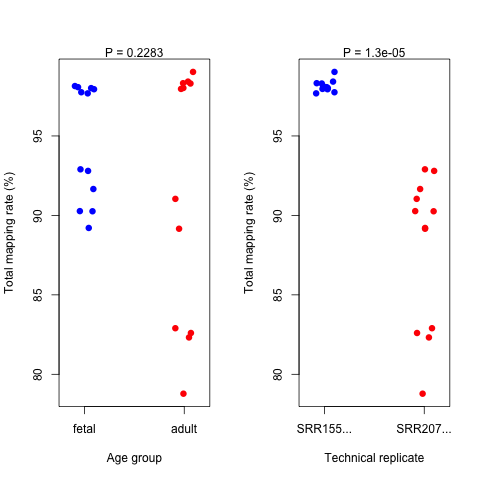

In [4]:
%%R
par(mfrow=c(1,2))
a<-data.frame(qc[qc$Age_group=="fetal", "Total_align_rate...."], qc[qc$Age_group=="adult", "Total_align_rate...."])
colnames(a)<-c("fetal", "adult")
Pv<-round(t.test(a$fetal, a$adult)$p.value, digits = 4)
stripchart(a, vertical=T, pch=16, cex=1.2, col=c("Blue", "Red"), method="jitter", ylab="Total mapping rate (%)", xlab="Age group")
mtext(paste("P =", Pv), side=3)
a<-data.frame(qc[qc$Techrep==1, "Total_align_rate...."], qc[qc$Techrep==2, "Total_align_rate...."])
colnames(a)<-c("SRR155...", "SRR207...")
Pv<-round(t.test(a[,1], a[,2])$p.value, digits = 6)
stripchart(a, vertical=T, pch=16, cex=1.2, col=c("Blue", "Red"), method="jitter", ylab="Total mapping rate (%)", xlab="Technical replicate")
mtext(paste("P =", Pv), side=3)



Based on using the ```R table()```function I found that there were no substantial difference (only minor) between the age group and the other QC parameters (e.g. per base seqence quality, per base sequence content,...). This was excluded from this document due to size limitation (5 pages). 

## 4 Quantification of transcript counts

I used featureCounts from the Subread package (v. 1.6.5). I provided an index of gene annotations from UCSC. I downloaded this through the table browser (Genes & Gene predictions, NCBI RefSeq, ncbiRefSeq All) and exported it in GTF format. 
```bash
%%bash
<path: to featureCounts app> -B -T 8 -a <path: to INDEX_GTF> -o <path: COUNTDATA_DIR> <path: BAMSORT_DIR>/*
```
This yielded a data frame of counts for features (gene transcripts, RefSeq annotation) per sample as shown below. 

In [5]:
%%R
expr = read.table("https://raw.githubusercontent.com/ecfischer/capstone2020/master/ExpressionSet.tab", sep="\t")

## 5 Explorative analysis of the data set
At this point I have a data set with abundance of each feature for each sample (```expr```). I also compiled a phenotype data table with information about each sample (```pdata```). I used this information to normalize the counts per million reads. 

It is clear from the boxplot shown below that there are no counts for most of the features.

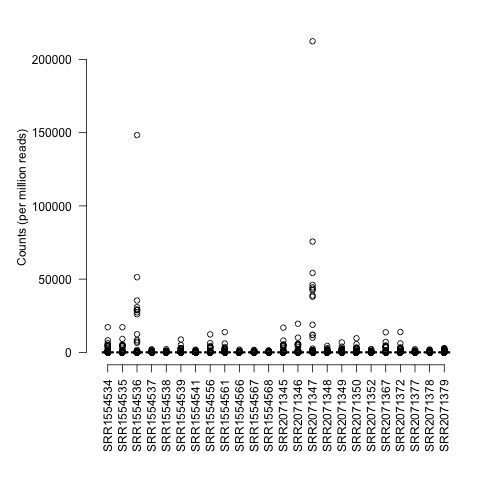

In [6]:
%%R
pdata = read.csv("https://raw.githubusercontent.com/ecfischer/capstone2020/master/pdata.csv", header=T, row.names=1)
expr_norm = t(t(expr) / (pdata$totalMapped/10^6))
par(mar=c(8,6,2,1))
boxplot(expr_norm, axes=F)
title(ylab="Counts (per million reads)", line=4)
axis(1, las=2, at=1:24, labels=colnames(expr), xlab="lolol")
axis(2, las=1)

By transforming the data using ```log2(expr_norm+1)``` and dropping features with low row means, we can see that the data looks relatively uniform for the different samples. Yet there are small differences that call for a normalization at a later stage. 

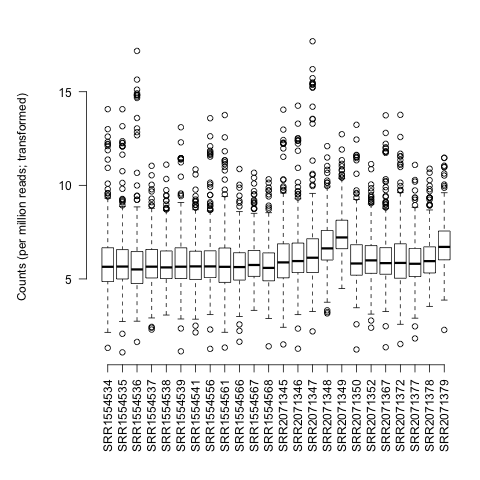

In [7]:
%%R
par(mar=c(8,6,2,1))
t_expr_norm0 = log2(expr_norm+1)
t_expr_norm = t_expr_norm0[rowMeans(t_expr_norm0) > 5, ]
boxplot(t_expr_norm, axes=F)
title(ylab="Counts (per million reads; transformed)", line=4)
axis(1, las=2, at=1:24, labels=colnames(expr), xlab="lolol")
axis(2, las=1)

To get an idea about trends in the data, I plottet the first two principle components against each other. This showed that the two age groups clearly cluster together. In contrast, there is no clear clustering between the technical replicates (1/2) or sex (Male/Female).

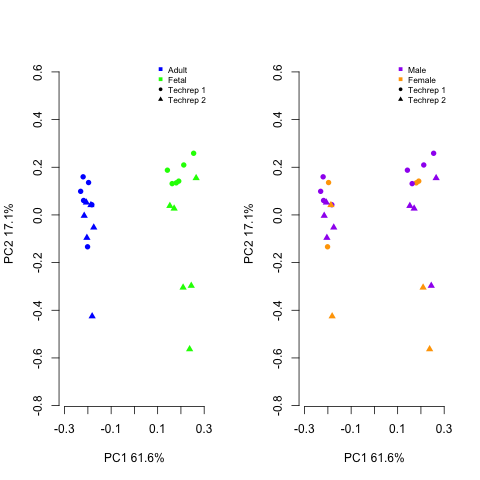

In [8]:
%%R
a = t_expr_norm
a_center  = a - rowMeans(a)
svd1 = svd(a_center)
explained_var = svd1$d**2/(sum(svd1$d**2))

par(mfrow=c(1,2))
col_age = ifelse(colnames(a_center) %in% rownames(pdata[pdata$AgeGroup == "adult",]), "Blue", "Green")
pch_tech = ifelse(colnames(a_center) %in% rownames(pdata[pdata$techrep == 1,]), 16, 17)
plot(x=svd1$v[,1], y=svd1$v[,2], ylim=c(-0.75,0.6), xlim=c(-0.3, 0.3), bty="n",ylab="", xlab="", col=col_age, pch=pch_tech)
title(xlab=paste("PC1 ", round(explained_var[1]*100,1), "%",sep=""), ylab=paste("PC2 ", round(explained_var[2]*100,1), "%",sep=""))
legend("topright", legend=c("Adult", "Fetal", "Techrep 1", "Techrep 2"), bty="n", pch=c(15, 15,16,17), cex=0.7, col=c("Blue", "Green", "Black", "Black"))

col_sex = ifelse(colnames(a_center) %in% rownames(pdata[pdata$Sex == "M",]), "Purple", "Orange")
plot(x=svd1$v[,1], y=svd1$v[,2], ylim=c(-0.75,0.6), xlim=c(-0.3, 0.3), bty="n",ylab="", xlab="", col=col_sex, pch=pch_tech)
title(xlab=paste("PC1 ", round(explained_var[1]*100,1), "%",sep=""), ylab=paste("PC2 ", round(explained_var[2]*100,1), "%",sep=""))
legend("topright", legend=c("Male", "Female", "Techrep 1", "Techrep 2"), bty="n", pch=c(15, 15,16,17), cex=0.7, col=c("Purple", "Orange", "Black", "Black"))

## 6 Identifying differentially expressed (DE) genes
I performed a statistical analysis on the count data to identify differentially expressed (DE) genes between the two agegroups (fetal/adult). First, I used the ```edgeR``` package (these don't want to install in Jupyter) to create ```DGEList``` list object from the raw count data and the total reads lengths). I used this to normalize the data and drop samples with low means. 
```
counts = DGEList(expr, lib.size = pdata$Total_reads)
counts0 = calcNormFactors(counts)
select = rowMeans(cpm(counts0)) > 1
counts = counts[select, ]
```
Then I created a model matrix, where the age group is the dependent variable, that adjusts for the technical replicate being a (potential) confounder. 
```
model = model.matrix(~pdata$AgeGroup + as.factor(pdata$techrep))
```
This allowed me to use ```voom``` from the ```limma```package to transform and normalize the data in one step. This function is designed for feeding the output directly into ```lmFit``` from the same package. 
```
y = voom(counts, model)
fit = lmFit(y, model) 
fit2 = eBayes(fit)
```
After model fitting I extracted the P values and coefficients. Since ```voom```does a log2 transformation the coefficients correspond to logFC between adult and fetal genes. I also use ```p.adjust()``` to correct P values for multiple testing using the Benjamini-Hochberg method. 

```
age_exp = data.frame("logFC(Agegroup)"=fit2$coefficients[,2],
  "Pvalues"=fit2$p.value[,2],
  "adjPvalues"=p.adjust(fit2$p.value[,2], method="BH"))
write.csv(<path>/age_exp.csv")

tech_exp = data.frame("logFC(Agegroup)"=fit2$coefficients[,3],
                    "Pvalues"=fit2$p.value[,3],
                    "adjPvalues"=p.adjust(fit2$p.value[,3], method="BH"))
write.csv(tech_exp, file="<path>/tech_exp.csv")
```
These data frames can be found below. 

In [9]:
%%R
age_exp = read.csv("https://raw.githubusercontent.com/ecfischer/capstone2020/master/age_exp.csv", row.names=1, header=T)
tech_exp = read.csv("https://raw.githubusercontent.com/ecfischer/capstone2020/master/tech_exp.csv", row.names=1, header=T)

Next, I generated Volcano plots for features with adjusted P value less than 0.1% for both age group and technical replicate. 

It is clear from the plots that the technical replicates had almost no effect (only **91** significant features). There is a sligthly  trend towards lower expression in replicate 2 versus that in replicate 1 (intercept). The plot for fetal versus adult is generally symmetric (**3459** significant features) but there is _slight_ trend towards higher FC in the fetal samples compared to the adult (intercept) features.

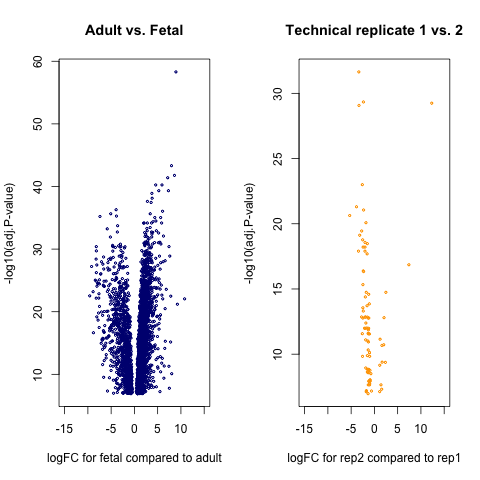

In [11]:
%%R
max_p = 0.001
par(mfrow=c(1,2))
plot(y=-log(age_exp[age_exp$adjPvalues < max_p, "adjPvalues"]), x=age_exp[age_exp$adjPvalues < max_p, "logFC.Agegroup."], pch=1, cex=0.4, xlim=c(-15,15), 
     main="Adult vs. Fetal", ylab="-log10(adj.P-value)", xlab="logFC for fetal compared to adult", col="Navy")

plot(y=-log(tech_exp[tech_exp$adjPvalues < max_p, "adjPvalues"]), x=tech_exp[tech_exp$adjPvalues < max_p, "logFC.Agegroup."], pch=1, cex=0.4, xlim=c(-15,15), 
     main="Technical replicate 1 vs. 2", ylab="-log10(adj.P-value)", xlab="logFC for rep2 compared to rep1", col="Orange")

## 7 Comparing DE genes to known histone markers
The histone acetylation marker H3K4me3 is associated with increased transcription. It has been mapped by ChIP-seq previously by the Epigenomics Roadmap project in both fetal and adult tissues. In this section, I compare the set of DE genes identified in the previous section (```P < 0.001```) to data sets mapping H3K4me3 marked regions in the genome. 

First, I quickly curate my set of DE genes. Since I used RefSeq for annotation I can easily distinguish between coding (NM), noncoding (NR), predicted coding (XM) and predicted noncoding RNAs (XR) identified in the set. I remove YP genes that are not relevant in the analysis and end up with the ```genes``` data frame shown below.

In [13]:
%%R
genes0 = age_exp
genes0 = genes0[genes0$adjPvalues < 0.001,]
genes = genes0[order(genes0[,1]),]
types = unlist(strsplit(rownames(genes), split="_"))[seq(1,length(rownames(genes))*2,2)]
genes = cbind(genes, "type"=types)
shortname = unlist(strsplit(rownames(genes), split='[.]'))[seq(1,length(rownames(genes))*2,2)]
genes = cbind(genes, shortname)
genes = genes[genes$type != "YP",]

Then, I download the data sets from the Epigenomics Roadmap via AnnotationHub. I decided to use the fetal male sample only since there are more male samples in my RNA-seq analysis (and since Sex did not matter much based on the PCA). 
```
%%R
ahub <- AnnotationHub()
ahub <-subset(ahub, species == "Homo sapiens")
#Updated date 2019-10-29

dlpc<-query(ahub, c("H3K4me3", "EpigenomeRoadMap", "E073", "narrowPeak"))[[1]]
liver<-query(ahub, c("H3K4me3", "EpigenomeRoadMap", "E066", "narrowPeak"))[[1]]
fetalm<-query(ahub, c("H3K4me3", "EpigenomeRoadMap", "E081", "narrowPeak"))[[1]]
```
Since the data was created for the Hg19 build, I use ```liftOver``` from the ```rtracklayer``` packages to convert the data to the Hg38 that my data was made with. I downloaded a chain file via UCSC to direct this conversion.
```bash
%%bash
wget --quiet http://hgdownload.cse.ucsc.edu/goldenpath/hg19/liftOver/hg19ToHg38.over.chain.gz -O <path: CHAIN>
```
This allows me to do:
```
chainfile = import.chain("<path: CHAIN>/hg19ToHg38.over.chain")
dlpc38<-unlist(liftOver(dlpc, chainfile))
liver38<-unlist(liftOver(liver, chainfile))
fetalm38<-unlist(liftOver(fetalm, chainfile))
```
To identify promoter regions I first create transcript database (```TxDb```) objects and find GRanges objects for (1) all promoters in RefSeq, only the promoters in the DE genes with fetal (2) upregulation and (3) downregulation (compared to adult samples). I restrict all the objects to chromosomes 1–22, X, and Y. 
```
## Full transcriptome
txfull <- makeTxDbFromUCSC(genome="hg38", tablename="ncbiRefSeq")
all0<-transcripts(txfull)
all<-subset(all0, seqnames %in% autosomes)
Pall<-promoters(all)

#Adult up
txa <- makeTxDbFromUCSC(genome="hg38", tablename="ncbiRefSeq", transcript_ids=rownames(genes[genes$logFC.Agegroup.<0,]))
a_up0<-transcripts(txa)
a_up<-subset(a_up0, seqnames %in% autosomes)
Pa_up<-promoters(a_up)

#Fetal up
txf <- makeTxDbFromUCSC(genome="hg38", tablename="ncbiRefSeq", transcript_ids=rownames(genes[genes$logFC.Agegroup.>0,]))
f_up0<-transcripts(txf)
f_up<-subset(f_up0, seqnames %in% autosomes)
Pf_up<-promoters(f_up)

```
Then I create a function for computing odds ratios between GRanges sets. 
````
compOR <- function(All_P, DE_P, H3){
  DE <- DE_P #This is the set of DE promoters (provided)
  notDE <- setdiff(All_P, DE_P, ignore.strand=T) #Defines the set of non-DE promoters 
  totH3 <- intersect(All_P, H3, ignore.strand=T) #Defines the set of total H3K4me3 marked regions in promoters only. 
  DE_and_H3 = sum(width(intersect(DE, totH3, ignore.strand=T)))/1000
  notDE_and_H3 = sum(width(intersect(notDE, totH3, ignore.strand=T)))/1000
  DE_not_H3 = sum(width(setdiff(DE, totH3, ignore.strand=T)))/1000
  notDE_notH3 = sum(width(setdiff(notDE, totH3, ignore.strand=T)))/1000
  OR <- DE_and_H3 * notDE_notH3 / (notDE_and_H3 * DE_not_H3)
  return(OR)
}
```
Finally, I compute the result of all combination of H3K4me3 regions for adult, fetal, and liver (control) versus up or downregulated fetal DE gene promoters. 
```
result = matrix(
c(
  compOR(All_P=Pall, DE_P=Pf_up, H3=dlpc38),
  compOR(All_P=Pall, DE_P=Pf_up, H3=fetalm38),
  compOR(All_P=Pall, DE_P=Pf_up, H3=liver38),
  compOR(All_P=Pall, DE_P=Pa_up, H3=dlpc38),
  compOR(All_P=Pall, DE_P=Pa_up, H3=fetalm38),
  compOR(All_P=Pall, DE_P=Pa_up, H3=liver38)
), 
nrow=3, ncol=2)
```

The results (figure below) show that the fetal upregulated DE genes are associated more with of the H3K4me3 markers in brain tissue than in liver tissue. Yet there is almost no difference between the fetal and adult markers. Perhaps this is because many genes that are very active in the fetal brain is still active at a lower level in the adult stage—which we cannot distinguish without incorporating the ChIP-seq signal value. It is, however, very clear that the fetal downregulated genes do not associate very much with the H3K4me3 marker. They associate much less than liver or adult, which makes sense since the H3K4me3 histone modification is thought to promote transcription in the region. Generally, the liver set show a difference in association between the up and down regulated genes, which we did not expect. This suggests that many of the identified DE genes are not solely involved in development (from fetal to adult) and some might not be involved at all but instead be more generally active and dynamic regions.
![alt text](https://raw.githubusercontent.com/ecfischer/capstone2020/master/OR.png)

## Summary
I have downloaded the data, performed alignment, QC, and extracted featureCounts based on fastq files from the original study. Then I explored the data using PCA and boxplots and identified DE genes with statistical analysis. Finally I compared DE genes to the H3K4me3 marker which assossicated with the DE gene promoters. Numerous DE genes were identified (>3000) between the fetal and adult samples. Yet it is not clear which of these are involved in brain development between these two age groups since many of the DE gene promoters also associate with the histone marker in other tissues as well. 